In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

dataset = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')

print(dataset)

      Gender        Age    Height      Weight family_history_with_overweight  \
0     Female  21.000000  1.620000   64.000000                            yes   
1     Female  21.000000  1.520000   56.000000                            yes   
2       Male  23.000000  1.800000   77.000000                            yes   
3       Male  27.000000  1.800000   87.000000                             no   
4       Male  22.000000  1.780000   89.800000                             no   
...      ...        ...       ...         ...                            ...   
2106  Female  20.976842  1.710730  131.408528                            yes   
2107  Female  21.982942  1.748584  133.742943                            yes   
2108  Female  22.524036  1.752206  133.689352                            yes   
2109  Female  24.361936  1.739450  133.346641                            yes   
2110  Female  23.664709  1.738836  133.472641                            yes   

     FAVC  FCVC  NCP       CAEC SMOKE  

In [3]:
# Define mappings for binary columns (0/1)
binary_map = {
    'Female': 1, 'Male': 0,
    'yes': 1, 'no': 0
}

# Define ordinal mappings (ordered by severity/frequency)
caec_map = {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}
calc_map = {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}
obesity_map = {
    'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2,
    'Overweight_Level_II': 3, 'Obesity_Type_I': 4, 'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
}

# Apply mappings to binary and ordinal features
dataset['Gender'] = dataset['Gender'].map(binary_map)
dataset['family_history_with_overweight'] = dataset['family_history_with_overweight'].map(binary_map)
dataset['FAVC'] = dataset['FAVC'].map(binary_map)
dataset['SMOKE'] = dataset['SMOKE'].map(binary_map)
dataset['SCC'] = dataset['SCC'].map(binary_map)
dataset['CAEC'] = dataset['CAEC'].map(caec_map)
dataset['CALC'] = dataset['CALC'].map(calc_map)
dataset['NObeyesdad'] = dataset['NObeyesdad'].map(obesity_map)

# One-Hot Encode MTRANS (Nominal Feature)
dataset = pd.get_dummies(dataset, columns=['MTRANS'], drop_first=True)

print("Encoded Data Head:\n", dataset.head().to_markdown(index=False, numalign="left", stralign="left"))

Encoded Data Head:
 | Gender   | Age   | Height   | Weight   | family_history_with_overweight   | FAVC   | FCVC   | NCP   | CAEC   | SMOKE   | CH2O   | SCC   | FAF   | TUE   | CALC   | NObeyesdad   | MTRANS_Bike   | MTRANS_Motorbike   | MTRANS_Public_Transportation   | MTRANS_Walking   |
|:---------|:------|:---------|:---------|:---------------------------------|:-------|:-------|:------|:-------|:--------|:-------|:------|:------|:------|:-------|:-------------|:--------------|:-------------------|:-------------------------------|:-----------------|
| 1        | 21    | 1.62     | 64       | 1                                | 0      | 2      | 3     | 1      | 0       | 2      | 0     | 0     | 1     | 0      | 1            | False         | False              | True                           | False            |
| 1        | 21    | 1.52     | 56       | 1                                | 0      | 3      | 3     | 1      | 1       | 3      | 1     | 3     | 0     | 1      | 1       

In [4]:
# Separate features (X) and target (y)
X = dataset.drop('NObeyesdad', axis=1)
y = dataset['NObeyesdad']

# Split data (70% train, 30% test, stratified to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define columns for scaling
continuous_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
discrete_cols = X.columns.difference(continuous_cols).tolist()

# Create a column transformer to apply StandardScaler only to continuous features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),
        ('cat', 'passthrough', discrete_cols)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

# Apply preprocessing and convert back to DataFrame
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=preprocessor.get_feature_names_out())
X_test_scaled = pd.DataFrame(X_test_scaled, columns=preprocessor.get_feature_names_out())

print(f"Data split and scaled. Training set shape: {X_train_scaled.shape}")

Data split and scaled. Training set shape: (1477, 19)


In [5]:
#Logistic Regression
results_summary = {}

# Train Logistic Regression
lr_model = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_accuracy = accuracy_score(y_test, lr_pred)

results_summary["Logistic Regression"] = {
    "Accuracy": lr_accuracy,
    "Best_Params": "N/A (Baseline)",
    "Report": classification_report(y_test, lr_pred, zero_division=0)
}

print(f"Logistic Regression Accuracy: {lr_accuracy*100:.2f}")
print("\nClassification Report:\n", results_summary["Logistic Regression"]["Report"])

Logistic Regression Accuracy: 87.85

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94        82
           1       0.84      0.71      0.77        86
           2       0.74      0.79      0.77        87
           3       0.83      0.84      0.83        87
           4       0.97      0.85      0.90       106
           5       0.87      0.99      0.93        89
           6       0.99      0.99      0.99        97

    accuracy                           0.88       634
   macro avg       0.88      0.88      0.87       634
weighted avg       0.88      0.88      0.88       634



In [6]:
#K-Nearest Neighbour (KNN)
import warnings
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Define parameter grid
knn_param_grid = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance']}

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    
    # Tune and train the model
    knn_grid = GridSearchCV(
        KNeighborsClassifier(), 
        knn_param_grid, 
        cv=5, 
        scoring='accuracy'
    )
    knn_grid.fit(X_train_scaled, y_train)

knn_best_model = knn_grid.best_estimator_
knn_pred = knn_best_model.predict(X_test_scaled)
knn_accuracy = accuracy_score(y_test, knn_pred)

results_summary["Optimized KNN"] = {
    "Accuracy": knn_accuracy,
    "Best_Params": knn_grid.best_params_,
    "Report": classification_report(y_test, knn_pred, zero_division=0)
}

print(f"Optimized KNN Accuracy: {knn_accuracy*100:.2f}")
print(f"Best Parameters: {knn_grid.best_params_}")
print("\nClassification Report:\n", results_summary["Optimized KNN"]["Report"])

Optimized KNN Accuracy: 84.54
Best Parameters: {'n_neighbors': 3, 'weights': 'distance'}

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.94      0.88        82
           1       0.83      0.40      0.54        86
           2       0.71      0.75      0.73        87
           3       0.72      0.92      0.81        87
           4       0.90      0.91      0.90       106
           5       0.94      0.98      0.96        89
           6       1.00      1.00      1.00        97

    accuracy                           0.85       634
   macro avg       0.85      0.84      0.83       634
weighted avg       0.85      0.85      0.83       634



In [7]:
#Support Vector Machine (SVM)
# Define parameter grid (focusing on rbf kernel for non-linearity)
svm_param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 0.1, 1], 'kernel': ['rbf']}

# Tune and train the model
svm_grid = GridSearchCV(SVC(random_state=42), svm_param_grid, cv=5, scoring='accuracy')
svm_grid.fit(X_train_scaled, y_train)
svm_best_model = svm_grid.best_estimator_
svm_pred = svm_best_model.predict(X_test_scaled)
svm_accuracy = accuracy_score(y_test, svm_pred)

results_summary["Optimized SVM"] = {
    "Accuracy": svm_accuracy,
    "Best_Params": svm_grid.best_params_,
    "Report": classification_report(y_test, svm_pred, zero_division=0)
}

print(f"Optimized SVM Accuracy: {svm_accuracy:.4f}")
print(f"Best Parameters: {svm_grid.best_params_}")
print("\nClassification Report:\n", results_summary["Optimized SVM"]["Report"])

Optimized SVM Accuracy: 0.9574
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97        82
           1       0.89      0.91      0.90        86
           2       0.91      0.89      0.90        87
           3       0.94      0.98      0.96        87
           4       0.98      0.98      0.98       106
           5       1.00      0.98      0.99        89
           6       1.00      1.00      1.00        97

    accuracy                           0.96       634
   macro avg       0.96      0.96      0.96       634
weighted avg       0.96      0.96      0.96       634



In [8]:
# Compile and display comparison summary
print("\n--- FINAL MODEL COMPARISON SUMMARY ---")
comparison_data = []
for model_name, res in results_summary.items():
    comparison_data.append({
        "Model": model_name,
        "Accuracy": f"{res['Accuracy']:.4f}",
        "Best Parameters": res['Best_Params']
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_markdown(index=False, numalign="left", stralign="left"))


--- FINAL MODEL COMPARISON SUMMARY ---
| Model               | Accuracy   | Best Parameters                              |
|:--------------------|:-----------|:---------------------------------------------|
| Logistic Regression | 0.8785     | N/A (Baseline)                               |
| Optimized KNN       | 0.8454     | {'n_neighbors': 3, 'weights': 'distance'}    |
| Optimized SVM       | 0.9574     | {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'} |


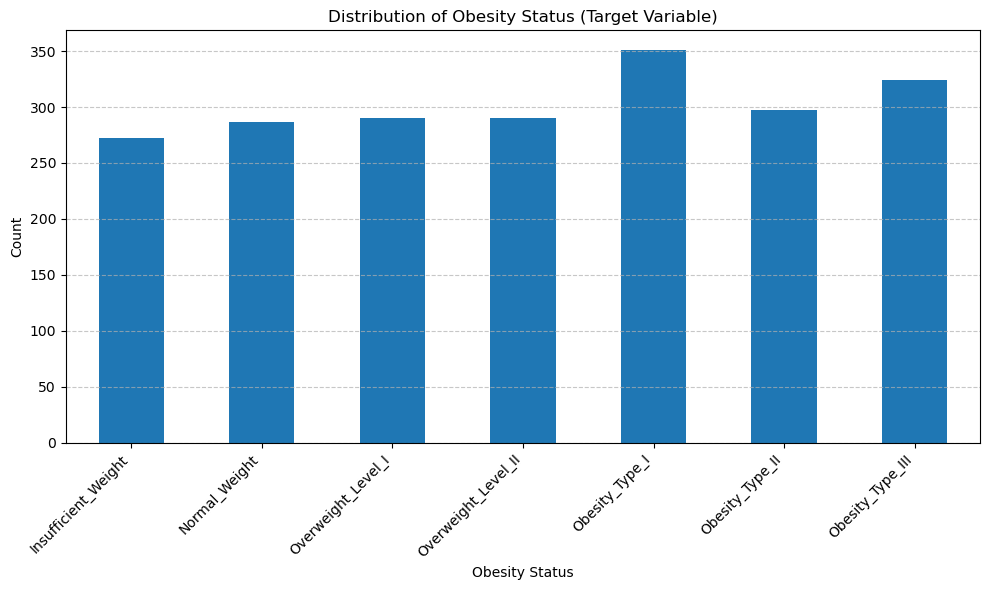

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
original_target_counts = pd.Series(y).map({v: k for k, v in obesity_map.items()}).value_counts().sort_index()

# Define order based on severity map
order = [
    'Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I',
    'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II',
    'Obesity_Type_III'
]
original_target_counts = original_target_counts.reindex(order)

original_target_counts.plot(kind='bar')
plt.title('Distribution of Obesity Status (Target Variable)')
plt.ylabel('Count')
plt.xlabel('Obesity Status')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show() # Use plt.savefig() 

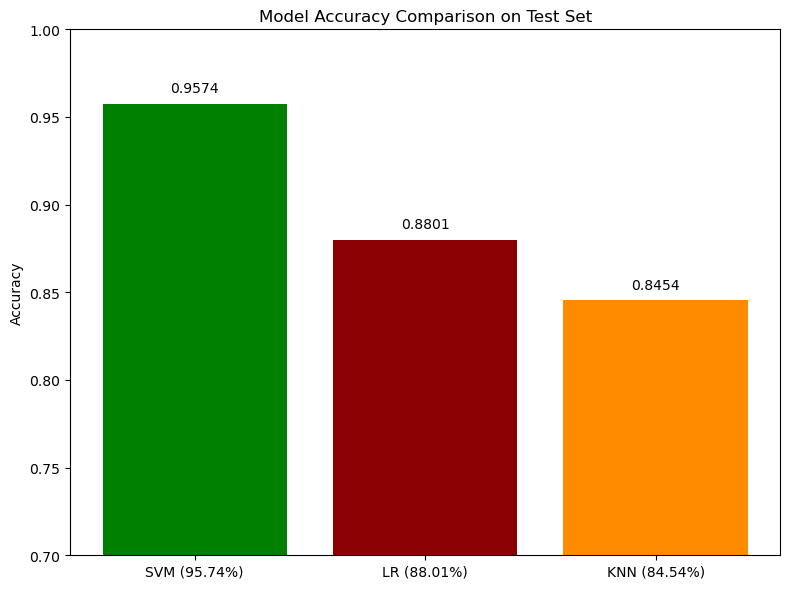

In [10]:
# Assuming 'model_accuracies' dictionary is defined
import matplotlib.pyplot as plt

model_accuracies = {
    "LR (88.01%)": 0.8801,  # Replace with actual variable names if defining earlier
    "KNN (84.54%)": 0.8454,
    "SVM (95.74%)": 0.9574
}

plt.figure(figsize=(8, 6))
accuracies = pd.Series(model_accuracies).sort_values(ascending=False)
bars = plt.bar(accuracies.index, accuracies.values, color=['green', 'darkred', 'darkorange'])
plt.title('Model Accuracy Comparison on Test Set')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1.0)
plt.xticks(rotation=0)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f'{yval:.4f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

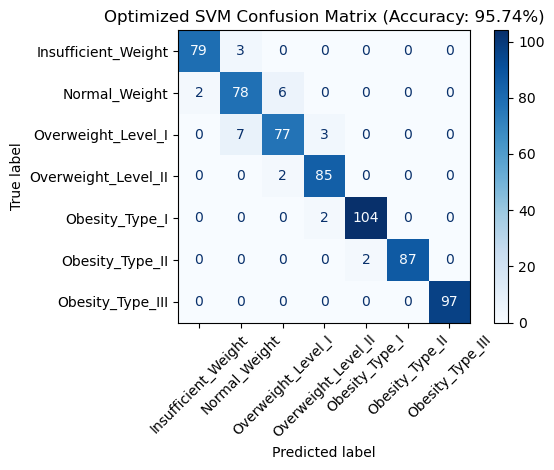

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# The original labels for clear plotting:
obesity_labels = [
    'Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I',
    'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II',
    'Obesity_Type_III'
]

cm = confusion_matrix(y_test, svm_pred)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=obesity_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Optimized SVM Confusion Matrix (Accuracy: 95.74%)')
plt.tight_layout()
plt.show()

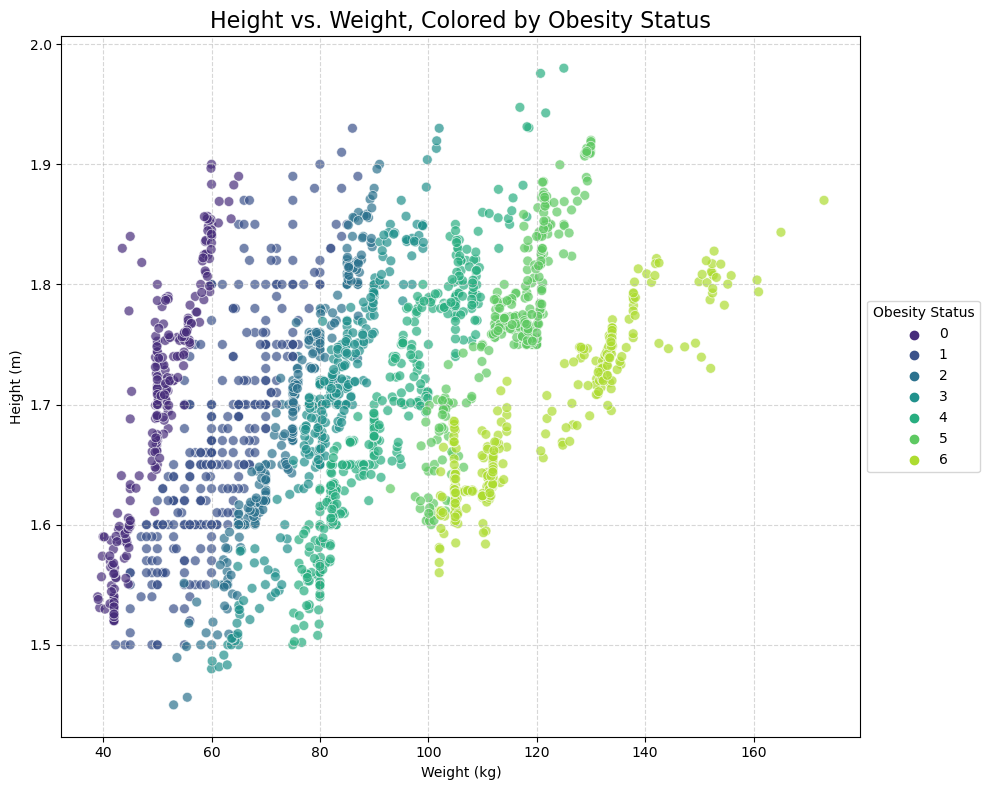

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'dataset' is loaded with original Height and Weight columns

# Encode the target variable for coloring the scatter plot
obesity_map = {
    'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2,
    'Overweight_Level_II': 3, 'Obesity_Type_I': 4, 'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
}
dataset['NObeyesdad_encoded'] = dataset['NObeyesdad'].map(obesity_map)

plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=dataset, 
    x='Weight', 
    y='Height', 
    hue='NObeyesdad', 
    palette=sns.color_palette("viridis", n_colors=7),
    s=50,
    alpha=0.7
)

plt.title('Height vs. Weight, Colored by Obesity Status', fontsize=16)
plt.xlabel('Weight (kg)')
plt.ylabel('Height (m)')
plt.legend(title='Obesity Status', loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(axis='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
